# Regularization

## Drop Out

```
- Nodes are randomly removed with a specified probability during training.
- It generally requires more training.
- It works better on deep networks.
- It works better with sufficient data.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import matplotlib.pyplot as plt

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

#### Mock Data Showing Dropout

```text
Note:
- PyTorch scales the input (node) by a factor, q
i.e.
```
$$wq$$

```text
where w = weight at the node, 
p = probability of dropout
q = scaling factor
```
$$q = \frac{1}{(1-p)}$$


In [3]:
prob = 0.5  #  probability of default
X = torch.ones(size=(15,))

# Initialize
dropout = nn.Dropout(p=prob)

# Apply dropout
# The output has been scaled up by a factor, q
y = dropout(X)

print(X)
torch.mean(X)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


tensor(1.)

In [4]:
# Elements with the value of 0 are the dropped nodes and elements
# with value of 2 are the scaled up nodes
print(y)
torch.mean(y)

tensor([0., 0., 2., 2., 2., 0., 0., 2., 2., 0., 2., 0., 2., 0., 0.])


tensor(0.9333)

In [5]:
# Dropout is turned off when evaluating the model
dropout.eval()
y = dropout(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [6]:
# OR (Using the functional implementation)
F.dropout(
    p=prob,
    input=X,
    training=False,  # apply dropout if is True
)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
# The model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(X)
print(f"With dropout: {y}\n")  # with dropout

dropout.eval()
y = dropout(X)
print(f"Without dropout: {y}")  # without dropout

With dropout: tensor([2., 2., 2., 2., 2., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0.])

Without dropout: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Example 1

```text
- Apply dropout to the training of a model.
```

In [8]:
# Create data
def create_circular_data(
    *, n_per_cluster: int, seed: int = 1
) -> tuple[torch.Tensor, torch.Tensor]:
    """This is used to generate a 2D circular data."""

    th = np.linspace(0, 4 * np.pi, n_per_cluster)
    r1, r2 = 10, 15

    # Seed the data generation
    np.random.seed(seed)

    # Generate data
    a = [
        r1 * np.cos(th) + np.random.randn(n_per_cluster) * 3,
        r1 * np.sin(th) + np.random.randn(n_per_cluster),
    ]
    b = [
        r2 * np.cos(th) + np.random.randn(n_per_cluster),
        r2 * np.sin(th) + np.random.randn(n_per_cluster) * 3,
    ]

    # True labels
    labels_np = np.vstack((np.zeros((n_per_cluster, 1)), np.ones((n_per_cluster, 1))))

    # Concatanate into a matrix
    data_np = np.hstack((a, b)).T

    # Convert to a pytorch tensor
    data, labels = torch.tensor(data_np).float(), torch.tensor(labels_np).float()
    return (data, labels)

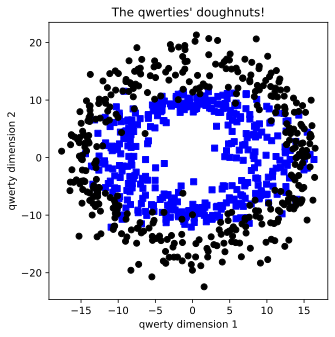

In [9]:
data, labels = create_circular_data(n_per_cluster=400)


# Visualize the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.title("The qwerties' doughnuts!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Split data
TEST_SIZE, RAMDOM_STATE = 0.2, 123
BATCH_SIZE = 16
X_train, X_validation, y_train, y_validation = train_test_split(
    data,
    labels,
    test_size=TEST_SIZE,
    random_state=RAMDOM_STATE,
)

X_train.shape, X_validation.shape

(torch.Size([640, 2]), torch.Size([160, 2]))

In [11]:
# Dataset objects
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

# Dataloader objects
train_DL = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
    shuffle=True,
)

In [12]:
class Net(nn.Module):
    """This is an ANN architecture."""

    def __init__(self, n_units: int, dropout_rate: float) -> None:
        super().__init__()
        # Layers
        self.input = nn.Linear(2, n_units)
        self.hidden = nn.Linear(n_units, n_units)
        self.output = nn.Linear(n_units, 1)

        # Parameters
        self.dr = dropout_rate  # probability of dropout

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = F.relu(self.input(X))

        # Dropout after the input layer
        # self.training automatically turns on/off during training/eval mode
        X = F.dropout(X, p=self.dr, training=self.training)

        # Dropout after the hidden layer
        X = F.relu(self.hidden(X))
        X = F.dropout(X, p=self.dr, training=self.training)

        # No Dropout at the output layer
        X = torch.sigmoid(self.output(X))

        return X

In [13]:
def train_model(
    *,
    train_data_loader: DataLoader,
    validation_data_loader: DataLoader,
    dropout_rate: float,
    n_units: int = 64,
) -> tuple[Any, Any]:
    """This is used to train the classifier."""
    net = Net(n_units=n_units, dropout_rate=dropout_rate)

    learning_rate, epochs = 0.01, 1_000
    THRESH, PCT = 0.5, 100
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    losses = torch.zeros(size=(epochs,))
    train_accuracy, validation_accuracy = [], []

    for epoch_idx in np.arange(epochs):
        batch_accuracy = []
        net.train()  # Activate regularization

        for X_, y_ in train_data_loader:
            # Reset gradients
            optimizer.zero_grad()

            # Compute forward prop and loss
            _y_proba = net(X_)
            loss = criterion(_y_proba, y_)

            # Compute backward prop
            loss.backward()
            optimizer.step()

            # Compute batch accuracy
            acc = torch.mean(((_y_proba > THRESH) == y_).float()) * PCT
            batch_accuracy.append(acc.detach())

        # Compute training accuracy
        train_accuracy.append(np.mean(batch_accuracy))

        # Compute validation accuracy
        net.eval()  # Deactivate regularization

        X_val, y_val = next(iter(validation_data_loader))
        y_proba_val = net(X_val)
        _val_acc = torch.mean(((y_proba_val > THRESH) == y_val).float()) * PCT
        validation_accuracy.append(_val_acc.detach())

    return (train_accuracy, validation_accuracy)

In [14]:
prob = 0.0
train_accuracy, validation_accuracy = train_model(
    train_data_loader=train_DL,
    validation_data_loader=validation_DL,
    dropout_rate=prob,
    n_units=64,
)

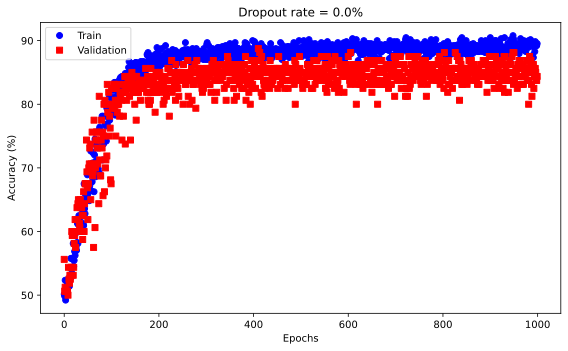

In [15]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_accuracy, "bo")
ax.plot(validation_accuracy, "rs")
ax.set(xlabel="Epochs", ylabel="Accuracy (%)", title=f"Dropout rate = {prob}%")

plt.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

In [16]:
# create a 1D smoothing filter
def smooth(x, k=5):
    """This is used to smoothen the plot"""
    return np.convolve(x, np.ones(k) / k, mode="same")

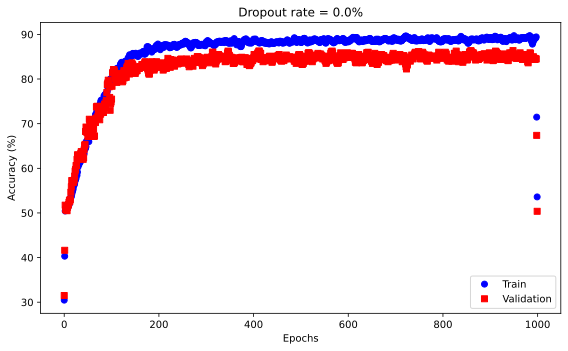

In [17]:
_, ax = plt.subplots(figsize=(8, 5))

ax.plot(smooth(train_accuracy), "bo")
ax.plot(smooth(validation_accuracy), "rs")
ax.set(xlabel="Epochs", ylabel="Accuracy (%)", title=f"Dropout rate = {prob}%")

plt.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()